<a href="https://colab.research.google.com/github/pabair/ml-kurs-ss21/blob/master/8_PyTorch_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Digits Example
This example classifies the digit dataset using a neural net.


First we need to install with `conda install pytorch` or `pip3 install torch` depending on your setup.

### 0. Preamble

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(1)
np.random.seed(1)

The following lines checks for GPU availability on the machine and sets the GPU as processing device (if available). If you are on Google Colab you can enable GPU support in the menu via `Runtime > Change runtime type` and select `GPU` as hardware accelerator.

In [2]:
if(torch.cuda.is_available()):
  processing_chip = "cuda:0"
  print(f"{torch.cuda.get_device_name(0)} available")
else:
  processing_chip = "cpu"
  print("No GPU available")

device = torch.device(processing_chip)
device

No GPU available


device(type='cpu')

### 1. Data Preperation

We work with the already know digit dataset. For more details on the dataset, check our [previous](https://github.com/pabair/ml-kurs-ss21/blob/master/2_Logistische_Regression_Digits.ipynb) notebook.


In [3]:
from sklearn.datasets import load_digits
data, labels = load_digits(return_X_y = True)

In [4]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state=0)

In [5]:
train_X

array([[ 0.,  0.,  0., ..., 16., 16.,  6.],
       [ 0.,  3., 12., ..., 16.,  2.,  0.],
       [ 0.,  1., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  6., ..., 11.,  0.,  0.]])

To be able to use the data in PyTorch, we need to convert them into PyTorch tensors. Such a tensor can be thought of an efficient way to represent lists and matrices (similar to Numpy), with the additional benefit that they can be moved to the GPU (the .to(device) part in the code below) and that they support automatic backpropagation (more on this later):

In [6]:
train_x = torch.Tensor(train_X).float().to(device)
test_x = torch.Tensor(test_X).float().to(device)
train_y =torch.Tensor(train_y).long().to(device)
test_y = torch.Tensor(test_y).long().to(device)

### 2. Model definition 


We define now the strucutre of our neural network. For this we create a class that is a subclass from PyTorch's nn.Module. By convention we put in the `__init__` method the layers we want to use in the network and in the `forward` method how data flows through this network.

Our network has 64 input features, one hidden layer with 5 neurons and 10 output neurons. The hidden layer uses a Relu activation function. Note that the output layer does not have a softmax activation (unlike we have seen it in the lecture). It rather gives out a raw score for each class (more on this later).

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden = nn.Linear(64, 5)
    self.output = nn.Linear(5, 10)

  def forward(self, x):
    z = F.relu(self.hidden(x))
    z = self.output(z)  # no softmax. see CrossEntropyLoss() 
    return z

### 3. Model Training

We can now start training our network. We run several epochs in which we first predict on the training data with our network and than backpropagate the loss. For this we use PyTorch's build-in optimizer that runs gradient descent on the weights of the network. Hence, in every episode we reduce the loss on the training data and improve our network.

As loss function we use cross entropy, which consumes the raw scores from the prediction and internally applies a softmax (that is why we do not need the softmax as last layer in the network).

Note that all training data is passed at once to our network (line `net(train_x)` ), since PyTorch will predict on all data points in parallel.

In [14]:
# create network, move it to device and set it to training-mode
net = Net().to(device)
net.train()

# define the parameters for training
no_epochs = 1000
learning_rate = 0.01
loss_func = nn.CrossEntropyLoss()  # applies softmax() internally
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

print("\nStarting training ")

train_losses = []
for epoch in range(0, no_epochs):

  optimizer.zero_grad()
  output = net(train_x)

  loss = loss_func(output, train_y)
  loss.backward()
  optimizer.step()

  train_losses.append(loss.item())
  
  if epoch % 100 == 0:
    print(f"Loss in epoch {epoch} is {loss.item()}")

print("Done training ")


Starting training 
Loss in epoch 0 is 4.306502342224121
Loss in epoch 100 is 1.6488325595855713
Loss in epoch 200 is 1.4033234119415283
Loss in epoch 300 is 0.9051334261894226
Loss in epoch 400 is 0.5831368565559387
Loss in epoch 500 is 0.46618589758872986
Loss in epoch 600 is 0.41099488735198975
Loss in epoch 700 is 0.3752268850803375
Loss in epoch 800 is 0.34888407588005066
Loss in epoch 900 is 0.32808351516723633
Done training 


Text(0, 0.5, 'loss')

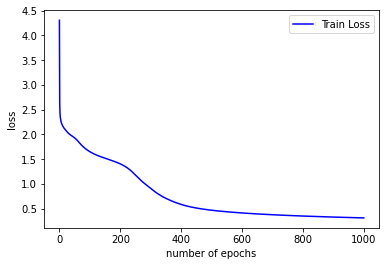

In [15]:
  fig = plt.figure()
  plt.plot(range(0, no_epochs), train_losses, color='blue')
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel('number of epochs')
  plt.ylabel('loss')

### 4. Model Evaluation

Finally, we check the model accuracy on the test data. For this we predict on the test data, identify the class with the highest score and compare it to the true label.

In [16]:
net.eval() # set network to evaluation mode
y_pred = net(test_x)
_, predicted = torch.max(y_pred.data, 1)
correct = (predicted == test_y).sum().item()
print(f"Accuarcy is {100. * correct / len(test_x)}%")

Accuarcy is 89.16666666666667%


### 5. Tasks

1. Our accuracy is not so good on the test data. Try the following to improve the model:
    - Increase the hidden layer size to 10 neurons, train the model and compare the accuracy on the test data.
    - Add a second hidden layer with 5 neurons, train the model and compare the accuracy on the test data.
2. Check if you can decrease the training loss even further if you train for more epochs. However, this can easily result in overfitting. To check that, calculate the accuracy on the test data already during training after each epoch. Show the plot the results as a second plot similiar to the one above. (Note: Normally we need to do this check on seperate validation data, not on our test data).